In [5]:
#下载数据
import requests
import urllib.request
url="https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a9a"
urllib.request.urlretrieve(url, "a9a")   #下载数据集

#加载数据：使用sklearn库的load_svmlight_file函数读取数据
from sklearn.datasets import load_svmlight_file
import numpy as np

X_train,y_train=load_svmlight_file("a9a",n_features=123)  #加载训练集数据
X_train=X_train.toarray()    #很重要！！！X稀疏矩阵数据格式需转换成nd.array形式
y_train=np.reshape(y_train,(y_train.shape[0],1))  
y_train=np.where(y_train == -1,0,y_train)   #将label（-1，1）转换成（0，1）

X_test,y_test=load_svmlight_file("a9a.t",n_features=123) #加载测试集数据
X_test=X_test.toarray()    #很重要！！！X稀疏矩阵数据格式需转换成nd.array形式
y_test=np.reshape(y_test,(y_test.shape[0],1))  
y_test=np.where(y_test == -1,0,y_test)   #将label（-1，1）转换成（0，1）

print(X_train.shape,type(X_train))
print(y_train.shape,type(y_train))
print(X_test.shape,type(X_test))
print(y_test.shape,type(y_test))


(32561, 123) <class 'numpy.ndarray'>
(32561, 1) <class 'numpy.ndarray'>
(16281, 123) <class 'numpy.ndarray'>
(16281, 1) <class 'numpy.ndarray'>


In [6]:
#逻辑回归及随机梯度下降
import random

def h(W,X):
    return 1/(1+np.exp(-1*np.dot(X,W)))

def grad(W,X_train,y_train,batch_size):  #逻辑回归梯度函数
    m,dim=np.shape(X_train)
    grad = np.ones([dim,1])
    for i in range(0,batch_size):
        index=random.randint(0, m-1)  #随机选择一个样本进行梯度下降
        X=X_train[index]
        y=y_train[index][0]   
        grad= grad+np.dot((h(W,X.reshape(1,dim))-y.reshape(1,1)),X.reshape(1,dim)).T
    return grad/batch_size

def J(W,X_test,y_test):     #逻辑回归,计算所有样本的损失函数
    return -np.average(np.dot(y_test.T,np.log(h(W,X_test)))+np.dot((1-y_test).T,(np.log(1-h(W,X_test)))))

def SGD(X_train,y_train,W,lr,batch_size):
    m,dim=np.shape(X_train)
    grad_t= grad(W,X_train,y_train,batch_size)
    W=W-lr*grad_t 
    #print(W.reshape(1,dim))
    return W

def NAG(X_train,y_train,W,gama,lr,batch_size):
    m,dim=np.shape(X_train)
    V= np.zeros([dim,1])       #初始化V全为1的n*1梯度     
    grad_t= grad(W-gama*V,X_train,y_train,batch_size)
    V=gama*V+lr*grad_t
    W=W-V 
    #print(W.reshape(1,dim))
    return W

def RMSProp(X_train,y_train,W,gama,lr,E,batch_size):
    m,dim=np.shape(X_train)
    G= np.zeros([dim,1])       #初始化G全为1的n*1梯度   
    grad_t=grad(W,X_train,y_train,batch_size)
    G=gama*G+(1-gama)*np.multiply(grad_t,grad_t)
    W=W-np.multiply(lr/(np.sqrt(G+E)),grad_t)
    return W


def AdaDelta(X_train,y_train,W,gama,E,batch_size):
    m,dim=np.shape(X_train)
    G= np.zeros([dim,1])       #初始化G全为1的n*1梯度
    T= np.zeros([dim,1])       #初始化T全为1的n*1梯度   
    grad_t=grad(W,X_train,y_train,batch_size)     
    G=gama*G+(1-gama)*np.multiply(grad_t,grad_t)
    delt_grad=np.multiply(-1*np.sqrt(T+E)/(np.sqrt(G+E)),grad_t)
    W=W+delt_grad
    T=gama*T+(1-gama)*np.multiply(delt_grad,delt_grad)
    return W

def Adam(X_train,y_train,W,gama,lr,E,beta,batch_size):
    m,dim=np.shape(X_train)
    G= np.zeros([dim,1])       #初始化G全为1的n*1梯度
    M= np.zeros([dim,1])       #初始化M全为1的n*1梯度         
    grad_t=grad(W,X_train,y_train,batch_size) 
    M=beta*M+(1-beta)*grad_t
    G=gama*G+(1-gama)*np.multiply(grad_t,grad_t)
    W=W-lr*M/(np.sqrt(G+E))
    return W


In [ ]:
def predict(X_test,y_test,W):   #预测正确率
    m,dim=np.shape(X_test)
    num_correct = 0
    yp=np.dot(X_test,W)
    for i in range(0,m):
        predict=-1
        target=y_test[i][0]
        if(yp[i][0]>0):
            predict=1
        if(predict*target)>0:
            num_correct+=1   
    return num_correct*1.0/m 

In [7]:
#设置参数
epochs=1000         #迭代轮数
batch_size=4000    
    
m,dim=np.shape(X_train)

losses_SGD=[]
W = np.zeros([dim,1])     #初始化W全为1或的n*1向量
lr=0.1
for i in range(0,epochs):       
    W=SGD(X_train,y_train,W,lr,batch_size)
    loss=J(W,X_test,y_test)
    losses_SGD.append(loss)
    #print("epochs:",i,"\t loss: ", loss)

losses_NAG=[]
W = np.zeros([dim,1])     #初始化W全为1或的n*1向量
gama=0.9
lr=0.1
for i in range(0,epochs):       
    W=NAG(X_train,y_train,W,gama,lr,batch_size)
    loss=J(W,X_test,y_test)
    losses_NAG.append(loss)
    #print("epochs:",i,"\t loss: ", loss)
        

losses_RMSProp=[]
W = np.zeros([dim,1])     #初始化W全为1或的n*1向量
gama=0.9
lr=0.001
E=1e-8
for i in range(0,epochs):       
    W=RMSProp(X_train,y_train,W,gama,lr,E,batch_size)
    loss=J(W,X_test,y_test)
    losses_RMSProp.append(loss)
    #print("epochs:",i,"\t loss: ", loss)
        
        
losses_AdaDelta=[]
W = np.zeros([dim,1])     #初始化W全为1或的n*1向量
gama=0.95
E=1e-6
for i in range(0,epochs):       
    W=AdaDelta(X_train,y_train,W,gama,E,batch_size)
    loss=J(W,X_test,y_test)
    losses_AdaDelta.append(loss)
        
        
losses_Adam=[]
W = np.zeros([dim,1])     #初始化W全为1或的n*1向量
gama=0.999
lr=0.001
E=1e-8
deta=0.9
for i in range(0,epochs):       
    W=Adam(X_train,y_train,W,gama,lr,E,deta,batch_size)
    loss=J(W,X_test,y_test)
    losses_Adam.append(loss)
    #print("epochs:",i,"\t loss: ", loss)

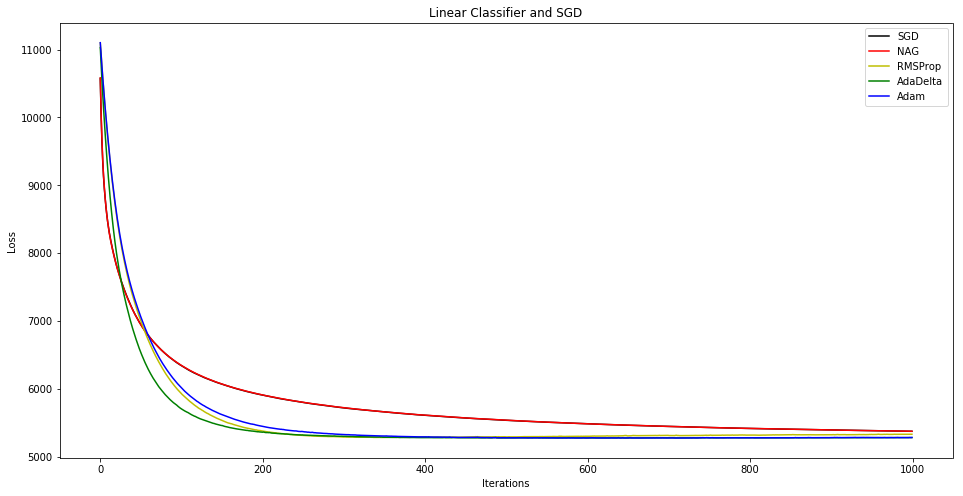

In [8]:
#画出图形
%matplotlib inline
import matplotlib.pyplot as plt

#loss figure
plt.figure(figsize=(16,8))
plt.plot(losses_SGD,color='black',label='SGD')
plt.plot(losses_NAG,color='r',label='NAG')
plt.plot(losses_RMSProp,color='y',label='RMSProp')
plt.plot(losses_AdaDelta,color='g',label='AdaDelta')
plt.plot(losses_Adam,color='b',label='Adam')
plt.legend(loc='upper right')
plt.title("Linear Classifier and SGD")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()
